# Sentiment analysis using CNN

## 1. Loading the dataset

### import libraries

In [ ]:
#Required libraries

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
from string import punctuation
import random
from wordcloud import WordCloud
import itertools
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import smart_open
smart_open.open = smart_open.smart_open

import nltk
from nltk.corpus import stopwords
from mlxtend.plotting import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import keras
from keras.layers import Flatten, LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding
from keras.models import Sequential
from keras import callbacks
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

seed = 1729


Lets import the movie reviews dataset

In [2]:
#movie reviews dataset
from nltk.corpus import movie_reviews

There are two folders, of which have 1000 positive and 1000 negative reviews. 

In [3]:
#reviews and sentiment
documents = [(list(movie_reviews.words(fileid)), category) for category in movie_reviews.categories() for fileid in movie_reviews.fileids(category)]

In [4]:
#documents as a dataframe object
df = pd.DataFrame(documents, columns = ["original_review", "sentiment"])
df = df.sample(frac = 1) #shuffle the dataframe
df.head()

,original_review,sentiment
1412,"[frequency, n, ., ,, the, number, of, times, a...",pos
1942,"[it, is, always, refreshing, to, see, a, super...",pos
1711,"[in, "", the, sweet, hereafter, ,, "", writer, /...",pos
977,"[i, saw, this, film, on, christmas, day, expec...",neg
1324,"[produced, by, robert, lantos, &, stephen, j, ...",pos


### Lets look if a dataset has any missing values and print the shape of dataframe. 

In [5]:
#null values
df.isnull().any()

original_review    False
sentiment          False
dtype: bool

There are no missing values.

In [6]:
#shape of the dataset
print(f"The shape of the dataframe is {df.shape}.")

The shape of the dataframe is (2000, 2).


## 2. Preprocessing

Before we use our dataset to construct the model, we need to perform data preprocessing such as removing punctuations, converting to lowercase, remove empty strings and remove any special characters.

In [7]:
#create a copy of dataframe
df1 = df.copy()

In [8]:
#preprocessing reviews
def datapreprocessingstep1(word):
    """remove any special characters""" 
    word = re.sub('[^a-zA-Z0-9]+', '', str(word))
    #result = re.sub(r'[0-9]+', 'number', word)
    return word

def datapreprocessingstep2(sentence):
    """remove empty string, punctuation and convert to lowercase """
    remove_empty_string = list(filter(lambda word: word != '', sentence))
    #no_empty_str = list(empty_str_filter)
    important_words = [w for w in remove_empty_string if not w in punctuation]
    lowercase = [w.lower() for w in important_words]
    return lowercase   

In [9]:
#preprocessing
temp = list()
for review in df1["original_review"]:
    result = datapreprocessingstep2(datapreprocessingstep1(word) for word in review)
    temp.append(result)
    
df1["processed_review"] = temp

In [10]:
#consider two columns
df1 = df1[["processed_review", "sentiment"]]

In [11]:
#join all the processed reviews
df1["sentences"] = [" ".join(review) for review in df1["processed_review"]]
df1.head()

,processed_review,sentiment,sentences
1412,"[frequency, n, the, number, of, times, a, spec...",pos,frequency n the number of times a specified ph...
1942,"[it, is, always, refreshing, to, see, a, super...",pos,it is always refreshing to see a superstar act...
1711,"[in, the, sweet, hereafter, writer, director, ...",pos,in the sweet hereafter writer director atom eg...
977,"[i, saw, this, film, on, christmas, day, expec...",neg,i saw this film on christmas day expecting an ...
1324,"[produced, by, robert, lantos, stephen, j, rot...",pos,produced by robert lantos stephen j roth direc...


The dataset has been preprocessed. Lets create a model using Keras library.

## 3. Model

In [12]:
#all the words in the reviews
all_words = list(itertools.chain.from_iterable(list(df1["processed_review"]))) #list of all the words in the dataset
word_count = sorted(Counter(all_words).items(), key = lambda item: item[1], reverse=True) #assign a label to words

Lets plot a histogram to see the distribution of the lengths of the reviews. 

(array([  1.,   2.,   7.,  21.,  48.,  78.,  74.,  91., 144., 144., 172.,
        152., 139., 164., 133., 107., 109.,  76.,  65.,  49.,  34.,  25.,
         19.,  32.,  24.,   9.,  15.,  10.,  11.,   7.,   6.,   5.,   6.,
          4.,   2.,   2.,   2.,   5.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.]),
 array([  17. ,   65.9,  114.8,  163.7,  212.6,  261.5,  310.4,  359.3,
         408.2,  457.1,  506. ,  554.9,  603.8,  652.7,  701.6,  750.5,
         799.4,  848.3,  897.2,  946.1,  995. , 1043.9, 1092.8, 1141.7,
        1190.6, 1239.5, 1288.4, 1337.3, 1386.2, 1435.1, 1484. , 1532.9,
        1581.8, 1630.7, 1679.6, 1728.5, 1777.4, 1826.3, 1875.2, 1924.1,
        1973. , 2021.9, 2070.8, 2119.7, 2168.6, 2217.5, 2266.4, 2315.3,
        2364.2, 2413.1, 2462. ]),
 <BarContainer object of 50 artists>)

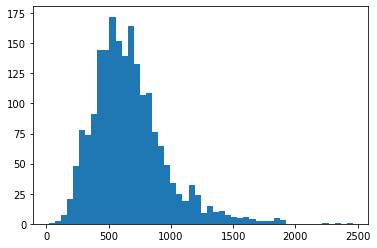

In [13]:
plt.hist([len(s) for s in df1["processed_review"]], bins=50)

From the histogram, we can see that there are many reviews with the length in the range between 200 and 1000. So, I am considering 1000 for a maximum length parameter. All the sentences have to be the same size. 

In [14]:
max_length = 1000 #maximum length
top_words = 5000 #top 5000 words
reviews = [review for review in df1["sentences"]] #concatenate reviews
#assign 1 for positive label and 0 for negative label
sentiments = [1 if label == "pos" else 0 for label in df1["sentiment"]]

Train and test splits

In [15]:
X_train, X_test, y_train, y_test = train_test_split(reviews, sentiments, test_size = 0.2, random_state = seed)

Here, we will need to tokenize our sentence using Tokenizer class by Keras. The parameter for num_words is set to 5000. This means that the tokenzier takes the first top 5000 most frequent words as features to build the model.

In [16]:
model = Tokenizer(num_words = top_words) #tokenize
model.fit_on_texts(X_train)
words_to_index = model.word_index #from string to int representation
vocab_length = len(words_to_index) #number of vocabulary

In [17]:
#pad sequences
X_tr = model.texts_to_sequences(X_train)
X_te = model.texts_to_sequences(X_test)
X_tr = pad_sequences(X_tr, maxlen = max_length)
X_te = pad_sequences(X_te, maxlen = max_length)

Create a embedding vector of size 200 

In [18]:
embedding_vector_length=200
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=max_length))

Four CNN layers with 32 neurons and kernel size of 3.

In [19]:
model.add(Conv1D(32, kernel_size= 3, padding= 'same', input_shape=(max_length, embedding_vector_length)))
model.add(Conv1D(32, kernel_size= 3, padding= 'same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(16, kernel_size= 3, padding= 'same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(16, kernel_size= 3, padding= 'same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_tr, y_train, epochs=5, batch_size=64)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/5
1600/1600 [==============================] - 4s 3ms/step - loss: 0.7158 - accuracy: 0.4888
Epoch 2/5
1600/1600 [==============================] - 4s 2ms/step - loss: 0.6157 - accuracy: 0.6700
Epoch 3/5
1600/1600 [==============================] - 4s 2ms/step - loss: 0.2625 - accuracy: 0.8906
Epoch 4/5
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0642 - accuracy: 0.9787
Epoch 5/5
1600/1600 [==============================] - 4s 2ms/step - loss: 0.0142 - accuracy: 0.9987


## 4. Test the classifier

In [20]:
y_pred = model.predict_classes(np.array(X_te))

In [21]:
target_names = [0,1]
cnf_matrix_test = confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       192
           1       0.84      0.79      0.81       208

    accuracy                           0.81       400
   macro avg       0.81      0.81      0.81       400
weighted avg       0.81      0.81      0.81       400



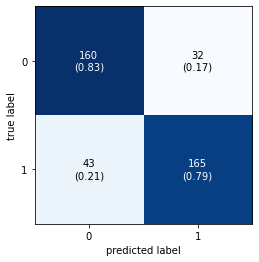

In [22]:
#confusion matrix
figure, ax = plot_confusion_matrix(conf_mat = cnf_matrix_test,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = False)
plt.show()

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 200)         1000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1000, 32)          19232     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1000, 32)          3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 500, 32)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 500, 16)           1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 16)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 250, 16)          

## 5. Error Analysis

In [47]:
#dictionary to store the values of reviews, predicted labels and true 
#labels of test set
ea_dict = {"reviews":[],
             "predicted":list(y_pred.reshape(len(y_pred,))),
             "true":y_test}

In [48]:
for num in range(len(X_test)):
    ea_dict["reviews"].append(X_test[num].split(" "))

In [50]:
#dataframe of ea_dict
dfea = pd.DataFrame(data=ea_dict)
dfea.head()

,reviews,predicted,true
0,"[bad, movies, described, as, a, swift, descent...",0,0
1,"[director, david, fincher, has, such, an, eye,...",1,1
2,"[comedy, rated, pg, runs, about, 1, 40, starri...",1,1
3,"[depending, on, your, degree, of, cinematic, a...",0,0
4,"[a, man, is, not, a, man, without, eight, tael...",1,1


In [55]:
#dataframe of misclassified labels
dfea1 = dfea[dfea['predicted'] != dfea['true']]
dfea1.head(10)

,reviews,predicted,true
5,"[it, s, been, hours, since, i, returned, from,...",1,0
11,"[play, it, to, the, bone, is, a, punch, drunk,...",1,0
17,"[one, of, the, most, respected, names, in, ame...",1,0
21,"[this, is, a, stagy, film, adapted, from, roge...",0,1
29,"[truman, true, man, burbank, is, the, perfect,...",0,1
30,"[best, remembered, for, his, understated, perf...",1,0
32,"[i, can, hear, the, question, already, what, o...",0,1
34,"[wyatt, earp, has, a, lot, to, tell, and, litt...",0,1
44,"[scream, 2, isn, t, quite, as, clever, as, its...",0,1
46,"[ugh, that, about, sums, this, movie, up, just...",1,0


As we can see from the above dataframe (dfea1), there are many reasons for mistakes. It is complicated to keep tab of mistakes. Some reviews have different words that is easier for human to assign label but algorithm might not be able to predict the labels correctly. This could be solved by bringing more data to train and create a huge collection of vocabulary.

### Error analysis statistics

In [60]:
#errors in true positive
print(f"Errors in true positive: {len(dfea1[dfea1['true'] == 1])}.")
print(f"Errors in true negative: {len(dfea1[dfea1['true'] == 0])}.")
print(f"Fraction of the errors with true positive: {43/1000}.")
print(f"Fraction of the errors with true negative: {32/1000}.")

Errors in true positive: 43.
Errors in true negative: 32.
Fraction of the errors with true positive: 0.043.
Fraction of the errors with true negative: 0.032.


## 6. Conclusion

In this notebook, we have explored the method to extract the sentiment analysis from movie reviews. This model is good to apply on unknown dataset. The accuracy of the model is 81%.